# Stochastic representation of ODEs

There are multiple interpretations of the stochasticity of a deterministic
ODE. We have implemented two of the most common interpretations; when the
parameters are realizations of some underlying distribution, and when we
have a so called chemical master equation where each transition
represent a jump. Again, we use the standard SIR example as previously
seen in {doc}`sir`.

In [1]:
from pygom import SimulateOde, Transition, TransitionType

import matplotlib.pyplot as plt

import numpy as np

# initial conditions
Ix0 = [1, 1.27e-6, 0]

# time period
t = np.linspace(0, 150, 100)

stateList = ['S', 'I', 'R']

paramList = ['beta', 'gamma']

transitionList = [Transition(origin='S', destination='I', equation='beta*S*I', transition_type=TransitionType.T), 
                  Transition(origin='I', destination='R', equation='gamma*I', transition_type=TransitionType.T)]

# create the ODEs
odeS = SimulateOde(stateList, paramList, transition=transitionList)

# assign parameter values
odeS.parameters = [0.5, 1.0/3.0]

# assign initial values
odeS.initial_values = (Ix0, t[0])

# solve deterministic solution
solutionReference = odeS.integrate(t[1::], full_output=False)


## Stochastic Parameters

In our first implementation, we assume that the parameters follow some
underlying distribution. Given that both $\beta$ and $\gamma$ in our SIR
model has to be non-negative, it seems natural to use a Gamma
distribution. We make use of the familiar syntax from
[R](http://www.r-project.org/) to define our distribution.
Unfortunately, we have to define it via a tuple, where the first item is the
function handle (name) and the second the parameters. 

```{note}
The parameters can be defined as either a dictionary or as the same sequence
as [R](http://www.r-project.org/) (without specifying the arguments), which for the [Gamma distribution](https://stat.ethz.ch/R-manual/R-devel/library/stats/html/GammaDist.html) is the shape followed by the rate.
```

In [2]:
from pygom.utilR import rgamma

d = dict()

# E(X) = 0.5 = shape * scale = shape / rate 
d['beta'] = (rgamma,{'shape':100.0, 'rate':200.0})

# E(X) = 1.0/3.0 = shape / rate
d['gamma'] = (rgamma,(100.0, 300.0))

odeS.parameters = d

Ymean, Yall = odeS.simulate_param(t[1::], 10, full_output=True)

```{note}
Note that a message may be printed above where PyGOM is trying to connect to an
mpi backend, as our module has the capability to compute in parallel
using the IPython. We have simulated a total of 10 different solutions
using different parameters, the plots can be seen below.
```


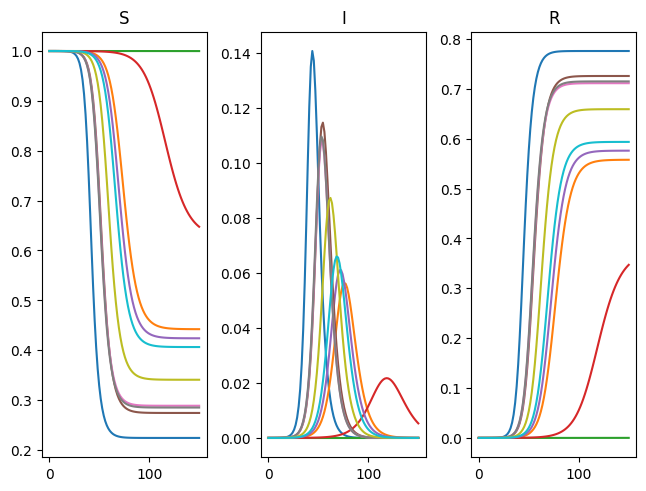

In [3]:
f, axarr = plt.subplots(1,3, layout='constrained')

#TODO tidy up plots
for solution in Yall:  
    axarr[0].plot(t, solution[:,0]) 
    axarr[1].plot(t, solution[:,1]) 
    axarr[2].plot(t, solution[:,2])

for idx, state in enumerate(stateList):
    axarr[idx].set_title(state)

plt.show()


We then see how the expected results, using the sample average of the
simulations

$$\tilde{x}(T) = \mathbb{E}\left[ \int_{t_{0}}^{T} f(\theta,x,t) dt \right]$$

differs from the reference solution

$$\hat{x}(T) = \int_{t_{0}}^{T} f(\mathbb{E}\left[ \theta \right],x,t) dt$$ 

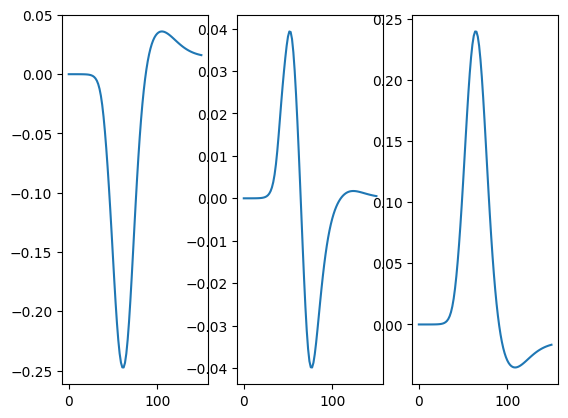

In [4]:
f, axarr = plt.subplots(1,3)

for i in range(3): 
    axarr[i].plot(t, Ymean[:,i] - solutionReference[:,i])

plt.show()



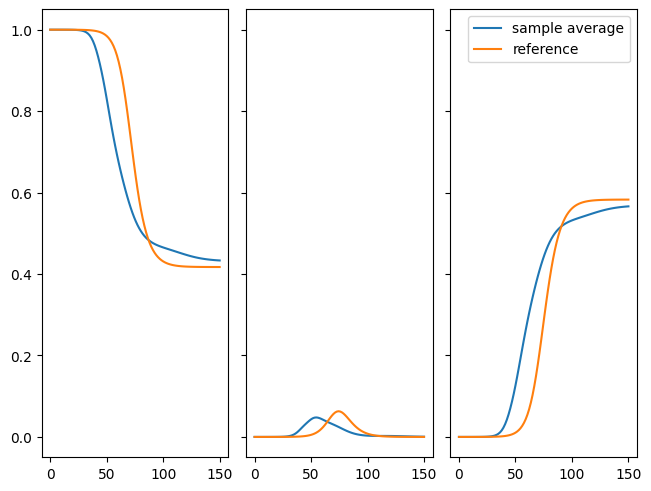

In [5]:
f, axarr = plt.subplots(1,3, layout='constrained', sharey=True)

for i in range(3): 
    axarr[i].plot(t, Ymean[:,i], label='sample average')
    axarr[i].plot(t, solutionReference[:,i], label='reference')

axarr[2].legend()
plt.show()


The difference is relatively large especially for the $S$ state. We can
decrease this difference as we increase the number of simulation, and
more sophisticated sampling method for the generation of random
variables can also decrease the difference.

In addition to using the built-in functions to represent stochasticity,
we can also use standard frozen distributions from scipy. Note that it
must be a frozen distribution as that is the only for the parameters of
the distributions to propagate through the model.

In \[1\]: import scipy.stats as st

In \[1\]: d = dict()

In \[1\]: d\['beta'\] = st.gamma(a=100.0, scale=1.0/200.0)

In \[1\]: d\['gamma'\] = st.gamma(a=100.0, scale=1.0/300.0)

In \[1\]: odeS.parameters = d

Obviously, there may be scenarios where only some of the parameters are
stochastic. Let's say that the $\gamma$ parameter is fixed at $1/3$,
then simply replace the distribution information with a scalar. A quick
visual inspection at the resulting plot suggests that the system of ODE
potentially has less variation when compared to the case where both
parameters are stochastic.

In \[1\]: d\['gamma'\] = 1.0/3.0

In \[1\]: odeS.parameters = d

In \[1\]: YmeanSingle, YallSingle = odeS.simulate_param(t\[1::\], 5,
full_output=True)

In \[1\]: f, axarr = plt.subplots(1,3)

In \[1\]: for solution in YallSingle:  
...: axarr\[0\].plot(t,solution\[:,0\]) ...:
axarr\[1\].plot(t,solution\[:,1\]) ...:
axarr\[2\].plot(t,solution\[:,2\])

@savefig stochastic_param_single.png In \[1\]: plt.show()

In \[1\]: plt.close()

## Continuous Markov Representation

Another common method of introducing stochasticity into a set of ode is
by assuming each movement in the system is a result of a jump process.
More concretely, the probabilty of a move for transition $j$ is governed
by an exponential distribution such that

$$\Pr(\text{process $j$ jump within time } \tau) = \lambda_{j} e^{-\lambda_{j} \tau},$$

where $\lambda_{j}$ is the rate of transition for process $j$ and $\tau$
the time elapsed after current time $t$.

A couple of the commmon implementation for the jump process have been
implemented where two of them are used during a normal simulation; the
first reaction method [\[Gillespie1977\]]() and the $\tau$-Leap method
[\[Cao2006\]](). The two changes interactively depending on the size of
the states.

In \[1\]: x0 = \[2362206.0, 3.0, 0.0\]

In \[1\]: stateList = \['S', 'I', 'R'\]

In \[1\]: paramList = \['beta', 'gamma', 'N'\]

In \[1\]: transitionList = \[  
...: Transition(origin='S', destination='I', equation='beta\*S\*I/N',
transition_type=TransitionType.T), ...: Transition(origin='I',
destination='R', equation='gamma\*I', transition_type=TransitionType.T)
...: \]

In \[1\]: odeS = SimulateOde(stateList, paramList,
transition=transitionList)

In \[1\]: odeS.parameters = \[0.5, 1.0/3.0, x0\[0\]\]

In \[1\]: odeS.initial_values = (x0, t\[0\])

In \[1\]: solutionReference = odeS.integrate(t\[1::\])

In \[1\]: simX, simT = odeS.simulate_jump(t\[1:10\], 10,
full_output=True)

In \[1\]: f, axarr = plt.subplots(1, 3)

In \[1\]: for solution in simX:  
...: axarr\[0\].plot(t\[:9\], solution\[:,0\]) ...:
axarr\[1\].plot(t\[:9\], solution\[:,1\]) ...: axarr\[2\].plot(t\[:9\],
solution\[:,2\])

@savefig stochastic_process.png In \[1\]: plt.show()

In \[1\]: plt.close()

Above, we see ten different simulation, again using the SIR model but
without standardization of the initial conditions. We restrict our time
frame to be only the first 10 time points so that the individual changes
can be seen more clearly above. If we use the same time frame as the one
used previously for the deterministic system (as shown below), the
trajectories are smoothed out and we no longer observe the *jumps*.
Looking at the raw trajectories of the ODE below, it is obvious that the
mean from a jump process is very different to the deterministic
solution. The reason behind this is that the jump process above was able
to fully remove all the initial infected individuals before any new
ones.

In \[1\]: simX,simT = odeS.simulate_jump(t, 5, full_output=True)

In \[1\]: simMean = np.mean(simX, axis=0)

In \[1\]: f, axarr = plt.subplots(1,3)

In \[1\]: for solution in simX:  
...: axarr\[0\].plot(t, solution\[:,0\]) ...: axarr\[1\].plot(t,
solution\[:,1\]) ...: axarr\[2\].plot(t, solution\[:,2\])

@savefig stochastic_process_compare_large_n\_curves.png In \[1\]:
plt.show()

In \[1\]: plt.close()

## Repeatable Simulation

One of the possible use of compartmental models is to generate
forecasts. Although most of the time the requirement would be to have
(at least point-wise) convergence in the limit, reproducibility is also
important. For both types of interpretation explained above, we have
given the package the capability to repeat the simulations by setting a
seed. When the assumption is that the parameters follows some sort of
distribution, we simply set the seed which governs the global state of
the random number generator.

In \[1\]: x0 = \[2362206.0, 3.0, 0.0\]

In \[1\]: odeS = SimulateOde(stateList, paramList,
transition=transitionList)

In \[1\]: d = {'beta': st.gamma(a=100.0, scale=1.0/200.0), 'gamma':
st.gamma(a=100.0, scale=1.0/300.0), 'N': x0\[0\]}

In \[1\]: odeS.parameters = d

In \[1\]: odeS.initial_values = (x0, t\[0\])

In \[1\]: Ymean, Yall = odeS.simulate_param(t\[1::\], 10,
full_output=True)

In \[1\]: np.random.seed(1)

In \[1\]: Ymean1, Yall1 = odeS.simulate_param(t\[1::\], 10,
full_output=True)

In \[1\]: np.random.seed(1)

In \[1\]: Ymean2, Yall2 = odeS.simulate_param(t\[1::\], 10,
full_output=True)

In \[1\]: sim_diff = \[np.linalg.norm(Yall\[i\] - yi) for i, yi in
enumerate(Yall1)\]

In \[1\]: sim_diff12 = \[np.linalg.norm(Yall2\[i\] - yi) for i, yi in
enumerate(Yall1)\]

In \[1\]: print("Different in the simulations and the mean: (%s, %s) " %
(np.sum(sim_diff), np.sum(np.abs(Ymean1 - Ymean))))

In \[1\]: print("Different in the simulations and the mean using same
seed: (%s, %s) " % (np.sum(sim_diff12), np.sum(np.abs(Ymean2 -
Ymean1))))

In the alternative interpretation, setting the global seed is
insufficient. Unlike simulation based on the parameters, where we can
pre-generate all the parameter values and send them off to individual
processes in the parallel backend, this is prohibitive here. In a
nutshell, the seed does not propagate when using a parallel backend
because each *integration* requires an unknown number of random samples.
Therefore, we have an additional flag **parallel** in the function
signature. By ensuring that the computation runs in serial, we can make
use of the global seed and generate identical runs.

In \[1\]: x0 = \[2362206.0, 3.0, 0.0\]

In \[1\]: odeS = SimulateOde(stateList, paramList,
transition=transitionList)

In \[1\]: odeS.parameters = \[0.5, 1.0/3.0, x0\[0\]\]

In \[1\]: odeS.initial_values = (x0, t\[0\])

In \[1\]: simX, simT = odeS.simulate_jump(t\[1:10\], 10, parallel=False,
full_output=True)

In \[1\]: np.random.seed(1)

In \[1\]: simX1, simT1 = odeS.simulate_jump(t\[1:10\], 10,
parallel=False, full_output=True)

In \[1\]: np.random.seed(1)

In \[1\]: simX2, simT2 = odeS.simulate_jump(t\[1:10\], 10,
parallel=False, full_output=True)

In \[1\]: sim_diff = \[np.linalg.norm(simX\[i\] - x1) for i, x1 in
enumerate(simX1)\]

In \[1\]: sim_diff12 = \[np.linalg.norm(simX2\[i\] - x1) for i, x1 in
enumerate(simX1)\]

In \[1\]: print("Difference in simulation: %s" %
np.sum(np.abs(sim_diff)))

In \[1\]: print("Difference in simulation using same seed: %s" %
np.sum(np.abs(sim_diff12)))